In [1]:
import os
import re
import sys
from collections import Counter
from glob import glob
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiMasker

%load_ext autoreload
%autoreload 2

from delay_discounting_mvpa.config_loader import Config

## Developing the functions that will be used in LSA analysis

Starting off with some basics for reading in data using the config file.  Note, the config is still really bloated and I'll trim it down later.

In [2]:
def resolve_file(cfg, subject_id: str, kind: str) -> Path:
    """
    Fetch a single file for a subject based on kind ('bold', 'mask', or 'behav').
    Ensures exactly one file is matched and returns it as a Path.

    Parameters
    ----------
    cfg : object
        Configuration object with .paths attributes.
    subject_id : str
        BIDS-style subject ID (no "sub-" prefix).
    kind : str
        One of 'bold', 'mask', or 'behav'.

    Returns
    -------
    Path
        The matched file path.

    Raises
    ------
    ValueError
        If kind is invalid or if zero/multiple files are found.
    """
    if kind == 'bold':
        pattern = (
            f'{cfg.paths.fmriprep_dir}/sub-{subject_id}/{cfg.paths.bold_file_glob}'
        )
    elif kind == 'mask':
        pattern = (
            f'{cfg.paths.fmriprep_dir}/sub-{subject_id}/{cfg.paths.bold_mask_file_glob}'
        )
    elif kind == 'behav':
        pattern = (
            f'{cfg.paths.behavior_dir}/{subject_id}_{cfg.paths.task_name}_events.tsv'
        )
    else:
        raise ValueError(
            f"Unknown file kind: {kind!r}. Must be 'bold', 'mask', or 'behav'."
        )

    matches = glob(pattern)

    if len(matches) == 0:
        raise ValueError(f'No files found for {kind!r} with pattern: {pattern}')
    if len(matches) > 1:
        raise ValueError(
            f'Multiple files found for {kind!r} with pattern: {pattern}\n{matches}'
        )

    return Path(matches[0])


def load_tsv_data(tsv_file: Path) -> pd.DataFrame:
    """Load behavioral data from a TSV file into a pandas DataFrame.

    Assumes the file exists and is a tab-separated .tsv file.
    """
    if tsv_file.suffix != '.tsv':
        raise ValueError(f'Expected a .tsv file, got: {tsv_file}')

    return pd.read_csv(tsv_file, sep='\t')

In [3]:
def get_subids(cfg):
    """
    Looks in cfg.paths.fmriprep_dir for folders starting with 'sub-s###'
    and extracts unique subject IDs.
    """
    subids = set()
    for d in os.listdir(cfg.paths.fmriprep_dir):
        full_path = os.path.join(cfg.paths.fmriprep_dir, d)
        if os.path.isdir(full_path):
            match = re.match(r'sub-s(\d+)', d)
            if match:
                subids.add('s' + match.group(1))
    return sorted(subids)

# Step 1: Check that the training data sets have fairly balanced labels for each fold
I'm assuming we'll be running a leave on subject out CV.  In some folds the test data will have all of the same label, but as long as the training data are balanced, it should be okay.

## Conclusion: The balance looks really good between the classes for each fold

In [4]:
cfg = Config(
    'config.yaml',
    validate=False,
)

In [5]:
subids = get_subids(cfg)

In [6]:
# Step 1: Build counts per subject
records = []

for subid in subids:
    try:
        behav_file = resolve_file(cfg, subid, 'behav')
        events_data_loop = load_tsv_data(behav_file)
    except (FileNotFoundError, KeyError, ValueError) as e:
        print(f'Skipping {subid} due to error: {e}')
        continue

    # Count the 'choice' values
    choice_counts = Counter(events_data_loop['choice'])

    records.append(
        {
            'subid': subid,
            'smaller_sooner': choice_counts.get('smaller_sooner', 0),
            'larger_later': choice_counts.get('larger_later', 0),
            'false': choice_counts.get('false', 0),
        }
    )

# Create dataframe
choice_counts_df = pd.DataFrame(records)
print(choice_counts_df)

Skipping s144 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s144_discountFix_events.tsv
Skipping s499 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s499_discountFix_events.tsv
Skipping s533 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s533_discountFix_events.tsv
Skipping s572 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s572_discountFix_events.tsv
Skipping s603 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s603_discountFix_events.tsv
Skipping s639 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s639_discountF

     fold test_sub  fraction_smaller  fraction_larger  total_valid_trials
0       1     s061          0.495589         0.504411               11790
1       2     s130          0.496098         0.503902               11790
2       3     s144          0.493619         0.506381               11910
3       4     s172          0.490755         0.509245               11790
4       5     s192          0.495844         0.504156               11790
..    ...      ...               ...              ...                 ...
103   104     s646          0.494741         0.505259               11790
104   105     s647          0.490120         0.509880               11791
105   106     s648          0.494911         0.505089               11790
106   107     s649          0.498516         0.501484               11793
107   108     s650          0.493711         0.506289               11847

[108 rows x 5 columns]


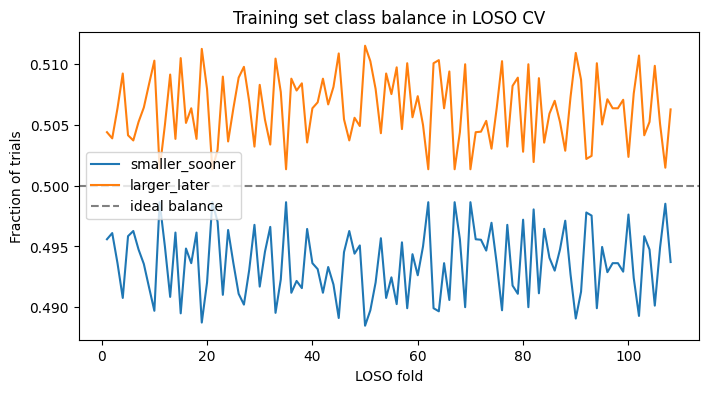

In [7]:
# Step 2: Assess LOSO training set balance
n_subs = len(subids)
fold_fractions = []

for test_idx, test_sub in enumerate(subids):
    # Exclude test subject
    train_df = choice_counts_df[choice_counts_df['subid'] != test_sub]

    # Sum counts across training subjects, ignoring 'false'
    train_smaller = train_df['smaller_sooner'].sum()
    train_larger = train_df['larger_later'].sum()

    total_valid = train_smaller + train_larger
    fraction_larger = train_larger / total_valid
    fraction_smaller = train_smaller / total_valid

    fold_fractions.append(
        {
            'fold': test_idx + 1,
            'test_sub': test_sub,
            'fraction_smaller': fraction_smaller,
            'fraction_larger': fraction_larger,
            'total_valid_trials': total_valid,
        }
    )

fold_balance_df = pd.DataFrame(fold_fractions)
print(fold_balance_df)

# Step 3: Visualize
plt.figure(figsize=(8, 4))
plt.plot(
    fold_balance_df['fold'], fold_balance_df['fraction_smaller'], label='smaller_sooner'
)
plt.plot(
    fold_balance_df['fold'], fold_balance_df['fraction_larger'], label='larger_later'
)
plt.axhline(0.5, color='gray', linestyle='--', label='ideal balance')
plt.xlabel('LOSO fold')
plt.ylabel('Fraction of trials')
plt.title('Training set class balance in LOSO CV')
plt.legend()
plt.show()

# Step 2: Run LSA for ROI mask for a single subject

* Build the design matrices and assess VIFs
* Pull out the ROI data
* Write a function to efficiently run the LSA model
* Write code to assess data for outliers (this may not make it into the notebook)


It turns out it isn't feasible to run all subjects in a notebook.  Here the focus is on developing the functions for obtaining whole brain LSA estimation.  After that, I'll move all of these functions to a python module and I'll write/run a script to obtain the LSA estimates for all subjects by submitting a batch job.

The mask I'm using here will be the `Precentral_L_mask.nii.gz` and the `Precentral_R_mask.nii.gz`, since Josh suggested I could use these for testing the code.  They each have about 3000-3500 voxels.


Notes from Josh:
The caudate, NAcc and OFC masks I would expect would decode and be interesting because these are involved in value-based decision-making (like people are doing here); activity patterns within the "Precentral" (motor ctx) masks may also decode choice, but not in an interesting way (b/c different choices could require different motor responses, depending on the specific task instructions).

## Read in behavioral data and create design matrices

Below I develop the code for construction the design matrices.  I then create all design matrices for all subjects and do some basic QA.

In [8]:
behav_file = resolve_file(cfg, subids[0], 'behav')
events_data_loop = load_tsv_data(behav_file)

In [9]:
import pandas as pd
from nilearn.glm.first_level.hemodynamic_models import spm_hrf, spm_time_derivative
from scipy.signal import fftconvolve


def make_stick_array(onsets, durations, length, resolution=0.2):
    """
    Efficient stick function as a NumPy array.
    """
    n_points = int(np.ceil(length / resolution))
    sf = np.zeros(n_points, dtype=np.float32)
    for onset, dur in zip(onsets, durations):
        start_idx = int(np.floor(onset / resolution))
        end_idx = int(np.ceil((onset + dur) / resolution))
        sf[start_idx:end_idx] = 1.0
    return sf


def create_cosine_drift(cutoff_hz, timepoints):
    """
    Create a discrete cosine basis set for high-pass filtering.

    Parameters
    ----------
    cutoff_hz : float
        Cutoff frequency in Hz (e.g., 1/128 for 128s cutoff).
    timepoints : array-like
        Time points (in seconds) for the design matrix.

    Returns
    -------
    dct_basis : np.ndarray
        Array of shape (len(timepoints), n_cosines)
    """
    t = np.array(timepoints)
    n = len(t)
    # Compute number of cosine functions to include
    n_cos = int(np.floor(2 * (t[-1] - t[0]) * cutoff_hz))
    if n_cos < 1:
        return np.zeros((n, 0))

    dct_basis = np.zeros((n, n_cos))
    for k in range(1, n_cos + 1):
        dct_basis[:, k - 1] = np.cos(np.pi * (2 * t + 1) * k / (2 * n))
    return dct_basis


def create_design_matrix(
    events_df_long,
    oversampling=20,  # reduce oversampling to save memory
    tr=1,
    num_trs=100,
    verbose=False,
    add_deriv=False,
    hp_filter=None,
):
    """
    Efficient design matrix creation using arrays and FFT convolution.
    """
    maxtime = tr * num_trs
    conv_resolution = tr / oversampling
    # timepoints_data = np.arange(0, maxtime, tr)
    timepoints_data = np.linspace(0, maxtime, num_trs, endpoint=False)
    timepoints_conv = np.arange(0, maxtime, conv_resolution)

    # Precompute HRF
    hrf = spm_hrf(tr, oversampling=oversampling)
    hrf_deriv = (
        spm_time_derivative(tr, oversampling=oversampling) if add_deriv else None
    )

    conv_dict = {}

    trial_types = events_df_long['trial_type'].unique()
    if verbose:
        print(
            f'Maxtime: {maxtime}, TRs: {num_trs}, conv points: {len(timepoints_conv)}'
        )

    for trial_type in trial_types:
        trial_events = events_df_long[events_df_long['trial_type'] == trial_type]
        onsets = trial_events['onset'].values
        durations = trial_events['duration'].values

        # Stick function as array
        sf_array = make_stick_array(onsets, durations, maxtime, conv_resolution)

        # Convolve with HRF using FFT for speed
        conv_signal = fftconvolve(sf_array, hrf)[: len(sf_array)]
        conv_dict[trial_type] = conv_signal[::oversampling]  # downsample to TRs

        if add_deriv:
            deriv_signal = fftconvolve(sf_array, hrf_deriv)[: len(sf_array)]
            conv_dict[f'{trial_type}_derivative'] = deriv_signal[::oversampling]

    # Build DataFrame in one go
    desmtx_conv = pd.DataFrame(conv_dict, index=timepoints_data)
    desmtx_conv['constant'] = 1.0

    # Optional high-pass filter
    if hp_filter:
        dct_basis = create_cosine_drift(hp_filter, timepoints_data)
        dct_df = pd.DataFrame(
            dct_basis, columns=[f'cosine{i}' for i in range(dct_basis.shape[1])]
        )
        dct_df = dct_df.loc[:, dct_df.nunique() > 1]
        desmtx_conv = pd.concat(
            [desmtx_conv.reset_index(drop=True), dct_df.reset_index(drop=True)], axis=1
        )

    return desmtx_conv


In [10]:
from typing import List, Tuple

import nibabel as nib
import pandas as pd
from nilearn.image import load_img

hp_filter_cutoff = 1 / 450


def create_design_matrices(
    cfg, subids: List[str], tr: float
) -> Tuple[List[str], List[str], List[pd.DataFrame]]:
    """
    Create first-level design matrices for each subject.

    Returns:
        valid_subids: list of subjects successfully processed
        bold_paths: list of BOLD paths corresponding to valid subjects
        design_matrices: list of DataFrames, one per subject
    """
    valid_subids = []
    bold_paths = []
    design_matrices = []

    for subid in subids:
        print(f'Processing {subid}...')
        # Load behavioral data
        try:
            behav_file = resolve_file(cfg, subid, 'behav')
            events_data_loop = load_tsv_data(behav_file)
        except (FileNotFoundError, KeyError, ValueError) as e:
            print(f'Skipping {subid} (behav error): {e}')
            continue

        # Load BOLD path
        try:
            bold_file = resolve_file(cfg, subid, 'bold')
        except (FileNotFoundError, KeyError, ValueError) as e:
            print(f'Skipping {subid} (BOLD missing): {e}')
            continue

        # Try to get number of TRs from header without loading full data
        try:
            bold_img = nib.load(bold_file)  # loads header only lazily
            n_scans = bold_img.shape[-1]
            scan_duration = n_scans * tr
        except Exception as e:
            print(f'Skipping {subid} (cannot read BOLD header): {e}')
            continue

        # Prepare events DataFrame
        events = pd.DataFrame(
            {
                'onset': events_data_loop['onset'],
                'duration': events_data_loop['duration'],
                'trial_index': np.arange(len(events_data_loop)),
            }
        )

        # Remove trials with negative onsets
        num_negative = (events['onset'] < 0).sum()
        if num_negative > 0:
            print(f'{subid}: removing {num_negative} trial(s) with negative onset(s)')
            events = events[events['onset'] >= 0].reset_index(drop=True)

        # Create trial_type after filtering
        events['trial_type'] = (
            events_data_loop.loc[events.index, 'choice']
            + '_'
            + (events['trial_index'] + 1).astype(str)
        )

        # Check that all events fit within the scan duration
        max_onset = events['onset'].max()
        if max_onset > scan_duration:
            print(
                f'Skipping {subid}: last event onset ({max_onset:.2f}s) exceeds '
                f'scan duration ({scan_duration:.2f}s)'
            )
            continue

        # Make design matrix
        try:
            design_matrix = create_design_matrix(
                events[['onset', 'duration', 'trial_type']],
                oversampling=10,
                tr=tr,
                num_trs=n_scans,
                hp_filter=hp_filter_cutoff,
            )
        except Exception as e:
            print(f'Skipping {subid} (design matrix error): {e}')
            continue

        # Store results
        valid_subids.append(subid)
        bold_paths.append(bold_file)
        design_matrices.append(design_matrix)

    return valid_subids, bold_paths, design_matrices


In [11]:
tr = cfg.fmri.tr
model_subids, bold_paths, design_matrices = create_design_matrices(cfg, subids, tr)

Processing s061...
Processing s130...
Processing s144...
Skipping s144 (behav error): No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s144_discountFix_events.tsv
Processing s172...
Processing s192...
Processing s234...
Processing s251...
Processing s358...
Processing s373...
Processing s445...
Processing s465...
Processing s471...
Processing s483...
Processing s491...
Skipping s491: last event onset (870.99s) exceeds scan duration (724.20s)
Processing s495...
Skipping s495: last event onset (735.04s) exceeds scan duration (724.20s)
Processing s497...
Processing s499...
Skipping s499 (behav error): No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s499_discountFix_events.tsv
Processing s512...
Processing s513...
Processing s518...
Processing s519...
Processing s524...
Processing s525...
Processing s526...
Processing s533...
Skipping s533 (behav error): No files

### Sort of odd that a few subjects had less data than they should have, so I'm quantifying that quickly.

In [12]:
# save out subjects who don't have enough BOLD data (relative to the max onset)


def check_scan_duration(cfg, subids: List[str], tr: float) -> pd.DataFrame:
    """
    Check that each subject's BOLD run is long enough to capture all behavioral onsets.

    Returns a DataFrame with columns:
        subid, num_trs_bold, length_run, max_onset
    for subjects where the scan is shorter than the max onset.
    """
    rows = []

    for subid in subids:
        try:
            behav_file = resolve_file(cfg, subid, 'behav')
            events_data = load_tsv_data(behav_file)
        except (FileNotFoundError, KeyError, ValueError) as e:
            print(f'Skipping {subid} (behav error): {e}')
            continue

        try:
            bold_file = resolve_file(cfg, subid, 'bold')
            bold_img = nib.load(bold_file)
            n_trs = bold_img.shape[-1]
            run_length = n_trs * tr
        except (FileNotFoundError, KeyError, ValueError, Exception) as e:
            print(f'Skipping {subid} (BOLD error): {e}')
            continue

        max_onset = events_data['onset'].max()

        if run_length < max_onset:
            rows.append(
                {
                    'subid': subid,
                    'num_trs_bold': n_trs,
                    'length_run': run_length,
                    'max_onset': max_onset,
                }
            )

    return pd.DataFrame(rows)

In [13]:
subjects_not_enough_bold = check_scan_duration(cfg, subids, tr)

Skipping s144 (behav error): No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s144_discountFix_events.tsv
Skipping s499 (behav error): No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s499_discountFix_events.tsv
Skipping s533 (behav error): No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s533_discountFix_events.tsv
Skipping s572 (behav error): No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s572_discountFix_events.tsv
Skipping s603 (behav error): No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s603_discountFix_events.tsv
Skipping s639 (behav error): No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s639_dis

In [14]:
subjects_not_enough_bold

,subid,num_trs_bold,length_run,max_onset
0,s491,1065,724.20,870.988
1,s495,1065,724.20,735.044
2,s649,339,230.52,606.248


## Write code for estimating VIFs and assess collinearity

Using the above design matrices I check the VIFs for all beta-series regressors for all subjects.  I did run this once without a highpass filter and everything looked great, except for a few betas for subject `s641`.  Unfortunately, with a highpass filter the VIFs do go up.  I've used a limited cutoff (1/350) and quantify the VIFS below with this threshold.  Once the betas are estimated for all subjects, we will run an outlier assessment (necessary even if the VIFs were all well controlled).

In [15]:
from nilearn.glm import expression_to_contrast_vector


def est_contrast_vifs(desmat, contrasts):
    """
    IMPORTANT: This is only valid to use on design matrices where each regressor represents a condition vs baseline
     or if a parametrically modulated regressor is used the modulator must have more than 2 levels.  If it is a 2 level modulation,
     split the modulation into two regressors instead.

    Calculates VIF for contrasts based on the ratio of the contrast variance estimate using the
    true design to the variance estimate where between condition correaltions are set to 0
    desmat : pandas DataFrame, design matrix
    contrasts : dictionary of contrasts, key=contrast name,  using the desmat column names to express the contrasts
    returns: pandas DataFrame with VIFs for each contrast
    """
    desmat_copy = desmat.copy()
    # find location of constant regressor and remove those columns (not needed here)
    desmat_copy = desmat_copy.loc[
        :, (desmat_copy.nunique() > 1) | (desmat_copy.isnull().any())
    ]
    # Scaling stabilizes the matrix inversion
    nsamp = desmat_copy.shape[0]
    desmat_copy = (desmat_copy - desmat_copy.mean()) / (
        (nsamp - 1) ** 0.5 * desmat_copy.std()
    )
    vifs_contrasts = {}
    for contrast_name, contrast_string in contrasts.items():
        contrast_cvec = expression_to_contrast_vector(
            contrast_string, desmat_copy.columns
        )
        true_var_contrast = (
            contrast_cvec
            @ np.linalg.inv(desmat_copy.transpose() @ desmat_copy)
            @ contrast_cvec.transpose()
        )
        # The folllowing is the "best case" scenario because the between condition regressor correlations are set to 0
        best_var_contrast = (
            contrast_cvec
            @ np.linalg.inv(
                np.multiply(
                    desmat_copy.transpose() @ desmat_copy,
                    np.identity(desmat_copy.shape[1]),
                )
            )
            @ contrast_cvec.transpose()
        )
        vifs_contrasts[contrast_name] = true_var_contrast / best_var_contrast
    return vifs_contrasts

In [16]:
design_matrices[0].columns

Index(['smaller_sooner_1', 'larger_later_2', 'smaller_sooner_3',
       'smaller_sooner_4', 'smaller_sooner_5', 'larger_later_6',
       'larger_later_7', 'larger_later_8', 'larger_later_9', 'larger_later_10',
       ...
       'smaller_sooner_114', 'larger_later_115', 'larger_later_116',
       'larger_later_117', 'larger_later_118', 'larger_later_119',
       'larger_later_120', 'constant', 'cosine0', 'cosine1'],
      dtype='object', length=123)

In [17]:
vif_dfs = []
for subid, desmat in zip(model_subids, design_matrices):
    contrasts = {
        col: col
        for col in desmat.columns
        if ('constant' not in col and 'cosine' not in col)
    }
    vif_ests = est_contrast_vifs(desmat, contrasts)
    vif_ests_df = pd.DataFrame(list(vif_ests.items()), columns=['regressor', 'vif'])
    vif_ests_df['subid'] = subid
    vif_dfs.append(vif_ests_df)

all_vifs_df = pd.concat(vif_dfs, ignore_index=True)


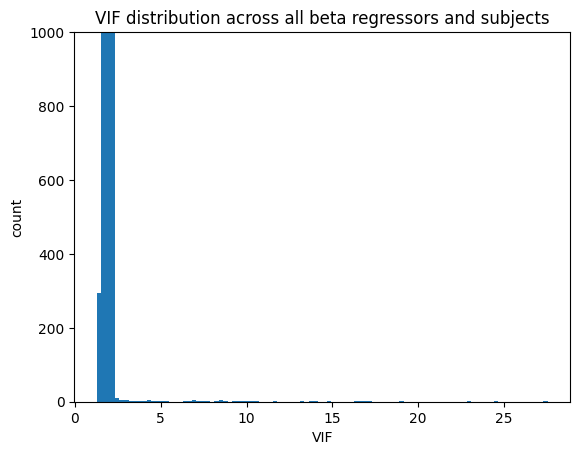

In [18]:
plt.hist(all_vifs_df['vif'], 100)
plt.ylim(0, 1000)
plt.title('VIF distribution across all beta regressors and subjects')
plt.xlabel('VIF')
plt.ylabel('count')
plt.show()

In [19]:
all_vifs_df.loc[all_vifs_df['vif'] > 5]

,regressor,vif,subid
1774,smaller_sooner_95,5.401657,s513
1775,smaller_sooner_96,6.951391,s513
1776,smaller_sooner_97,5.404501,s513
1777,smaller_sooner_98,7.441722,s513
1778,smaller_sooner_99,9.622373,s513
1779,smaller_sooner_100,7.238670,s513
1780,smaller_sooner_101,7.060241,s513
1781,smaller_sooner_102,7.732653,s513
1782,smaller_sooner_103,8.499838,s513
1783,smaller_sooner_104,10.694081,s513


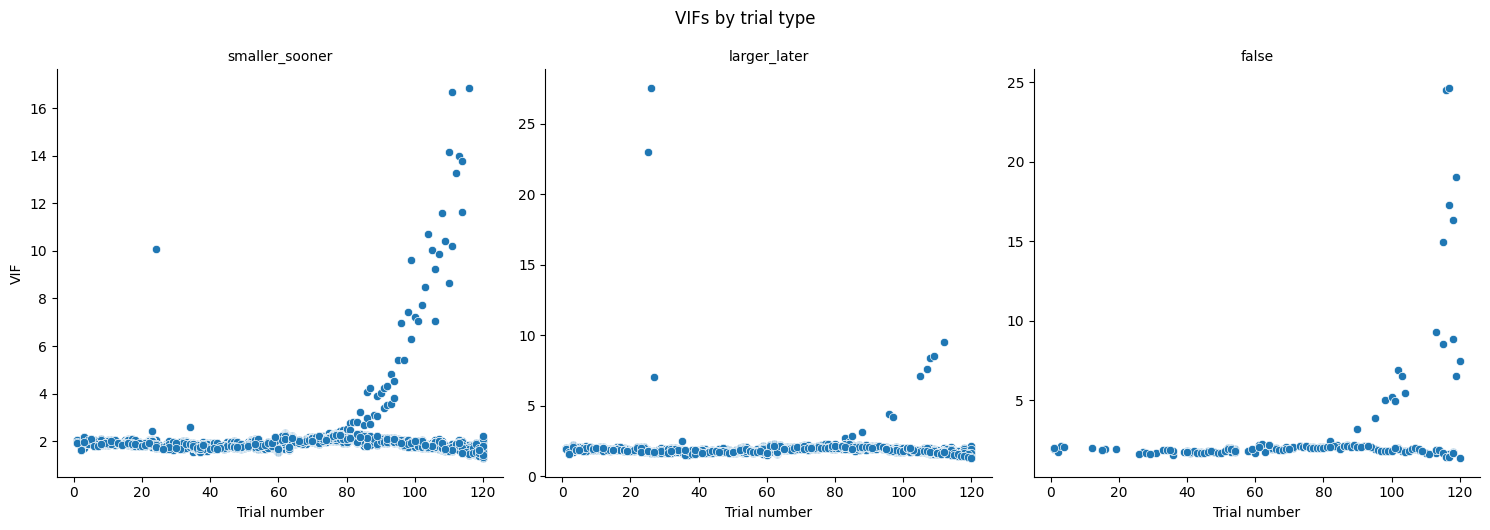

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Example: split "larger_later_80" into "larger_later" and 80
all_vifs_df[['trial_type', 'trial_number']] = all_vifs_df['regressor'].str.rsplit(
    '_', n=1, expand=True
)  # split on last "_"
all_vifs_df['trial_number'] = all_vifs_df['trial_number'].astype(int)

# Plot: 3 panels, one for each trial_type
g = sns.relplot(
    data=all_vifs_df,
    x='trial_number',
    y='vif',
    col='trial_type',  # makes panels
    kind='scatter',  # or "scatter"
    col_wrap=3,  # wrap into rows if >3
    facet_kws={'sharey': False},  # separate y-axis scales if needed
)

g.set_axis_labels('Trial number', 'VIF')
g.set_titles('{col_name}')  # show trial_type as title
plt.suptitle('VIFs by trial type', y=1.05)
plt.show()


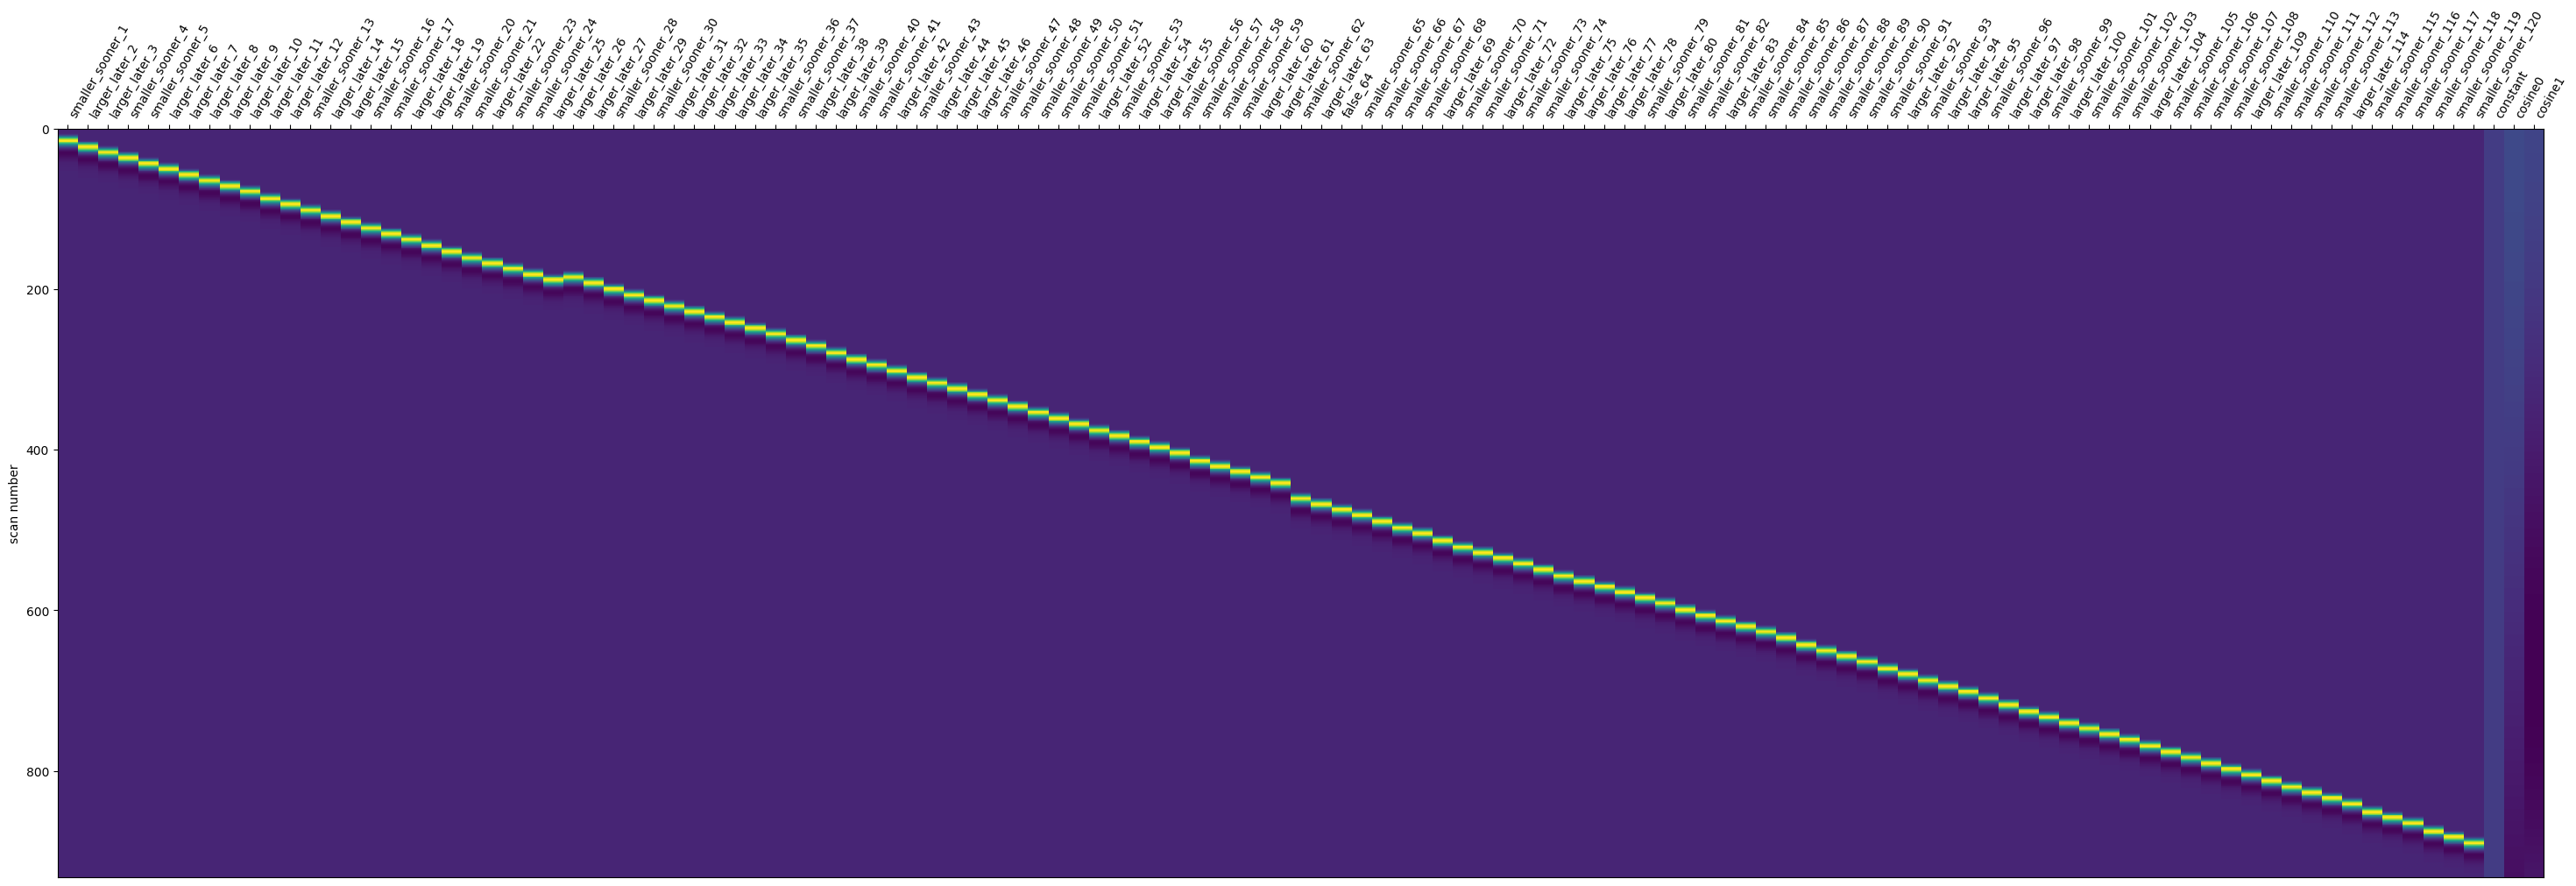

In [21]:
# have a look at subject 641 (This subject had high VIFs when there wasn't a highpass filter included)
# model_subids, bold_paths, design_matrices

from nilearn.plotting import plot_design_matrix

idx = model_subids.index('s641')


plot_design_matrix(design_matrices[idx])
plt.show()

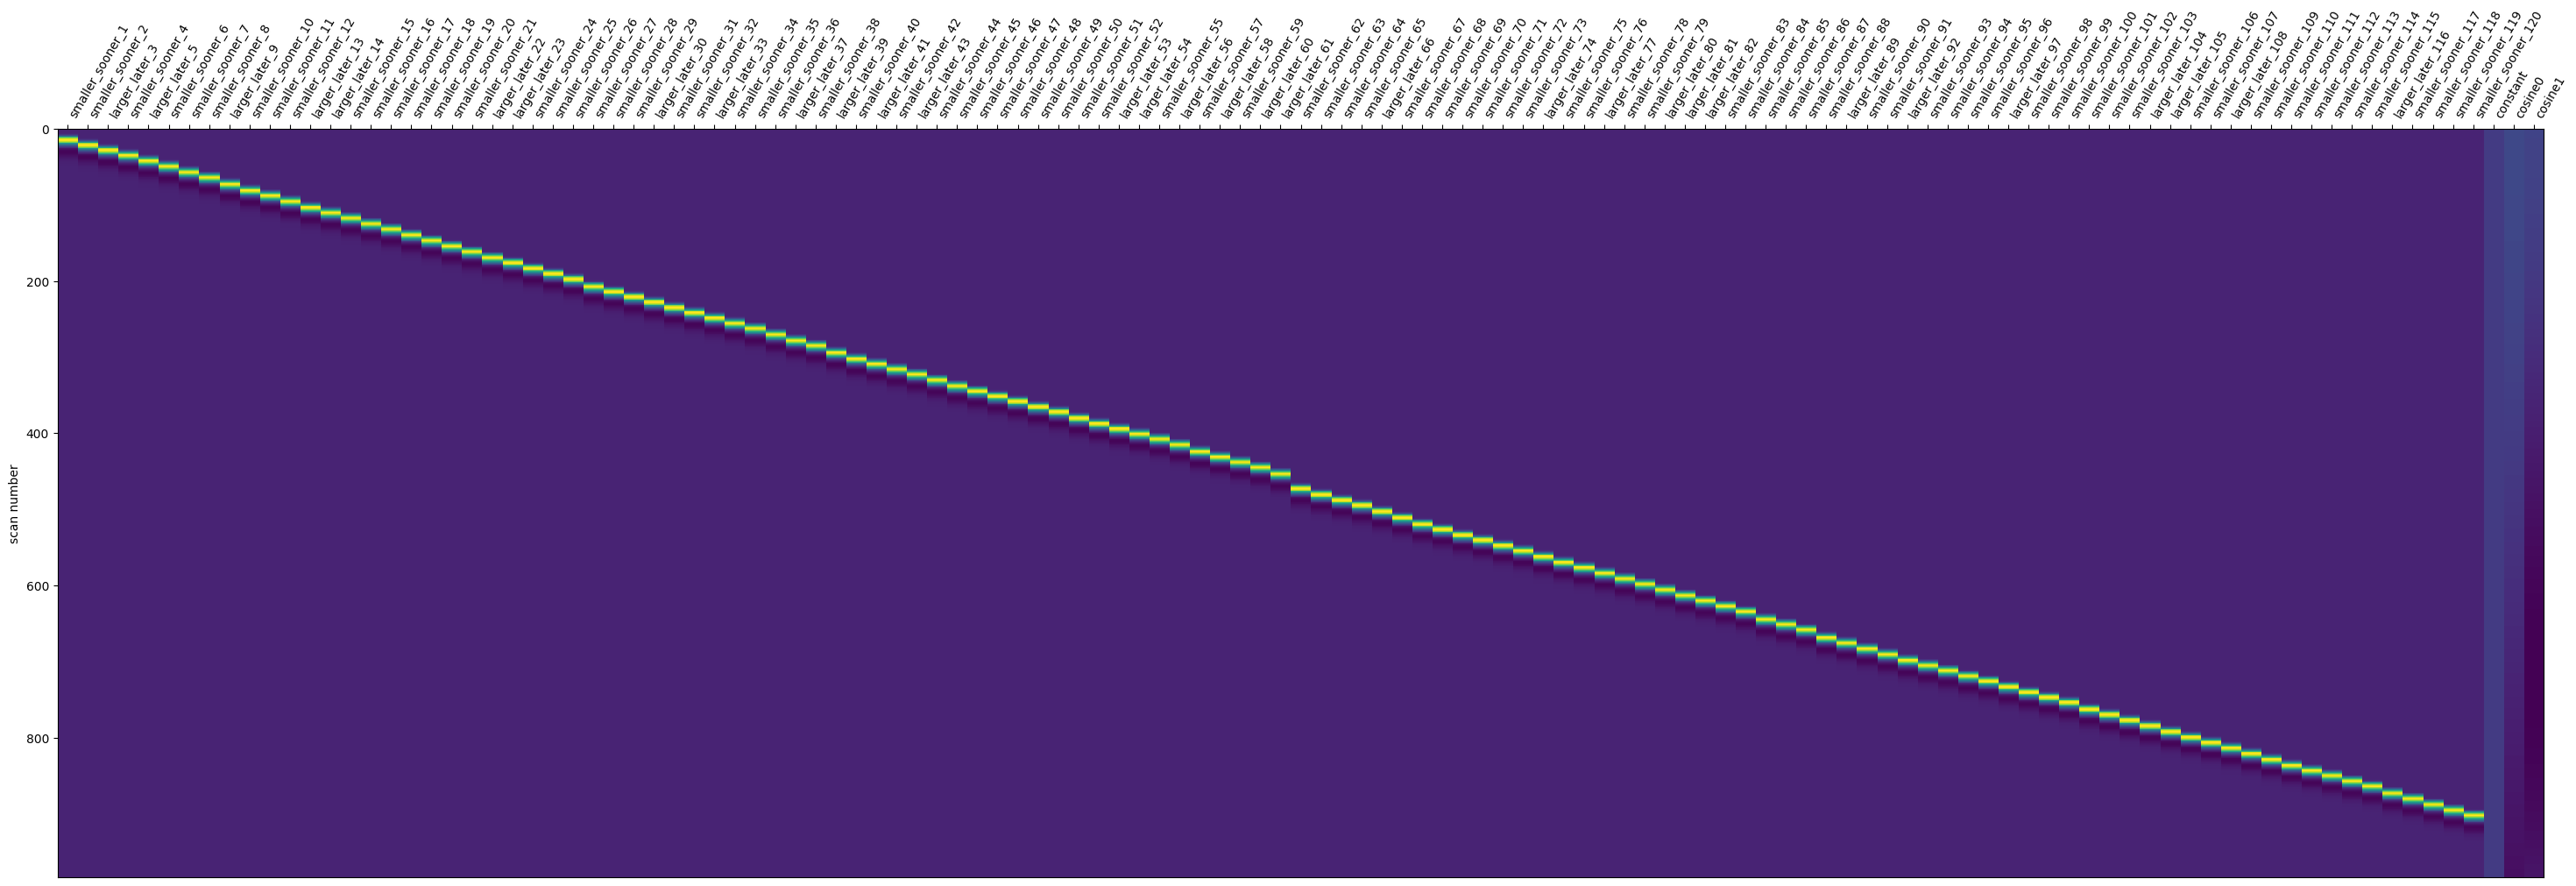

In [22]:
# Compare to a different subject
idx = 30


plot_design_matrix(design_matrices[idx])
plt.show()

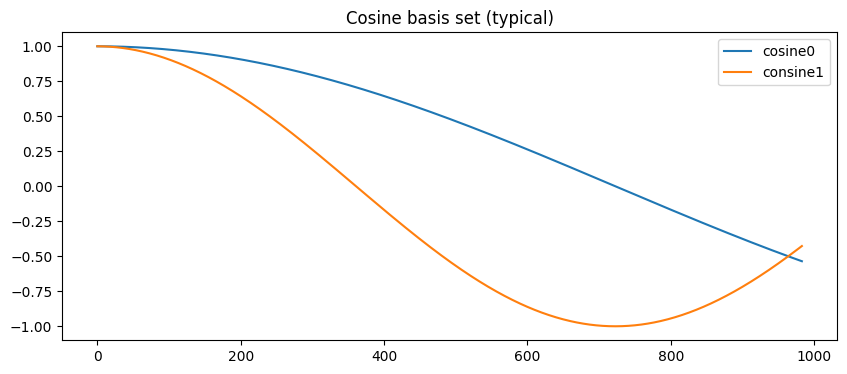

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(design_matrices[idx]['cosine0'], label='cosine0')
plt.plot(design_matrices[idx]['cosine1'], label='consine1')
plt.title('Cosine basis set (typical)')
plt.legend()
plt.show()

### VIF exploration summary
It looks like subject 641 has some issues, but only with 4 of the estimates when there isn't a highpass filter (results aren't shown here).  Obviously with the HP filter added the problem remains.  Just noting it, but later on we'll assess all beta images for outliers and we'll pay closer attention to the high VIF betas marked above.

## Pull out data for ROI 
These functions will serve a couple of purposes.  Here I'm interested in pulling out the BOLD data for an ROI, scaling by the average of the mean time series across all voxels in the brain (not just the ROI) and then multiplying by 100.  This step is necessary so the parameter estimates across subjects are in the same scale.  I'm making the scaling optional, since in the future I'll use the same functions to read in the beta series estimates and the scaling isn't needed for that.

It turns out it takes a long time to read in the BOLD data, which is why this notebook is only estimating the LSA estimates for the voxels in a single ROI.  The main LSA estimation will be run in a slurm job, but will use these functions.

In [24]:
mask = Path(f'{cfg.paths.masks_dir}/Precentral_L_mask.nii.gz')
mask.exists()

True

In [25]:
# write a function that takes as input the subjid and mask file and returns the data in the mask
from pathlib import Path

from nilearn.image import resample_to_img
from nilearn.input_data import NiftiMasker


def calculate_grand_mean_scale(cfg, subid):
    """
    Compute brain scale factor and scaled whole-brain data.

    Parameters
    ----------
    cfg : object
        Configuration object.
    subid : str
        Subject ID.

    Returns
    -------
    scale_factor : float
        Factor to scale global mean to 100.
    scaled_brain_data : np.ndarray
        2D (timepoints x voxels) scaled whole-brain data.
    brain_masker : NiftiMasker
        Fitted masker for inverse-transform.
    """
    bold_file = resolve_file(cfg, subid, 'bold')
    brain_mask_file = resolve_file(cfg, subid, 'mask')

    brain_masker = NiftiMasker(mask_img=brain_mask_file, standardize=False)
    brain_data = brain_masker.fit_transform(bold_file)

    grand_mean = brain_data.mean()
    scale_factor = 100.0 / grand_mean

    scaled_brain_data = brain_data * scale_factor
    return scale_factor, scaled_brain_data, brain_masker


def load_and_gm_scale_bold_data(cfg, subid, mask_type='brain', roi_mask_name=None):
    """
    Load and grand mean scale BOLD data for brain or ROI.
    Note: The scale factor is 100 divided by the mean of the mean BOLD
          time series within the brain mask (even when an roi_mask is used.)

    Parameters
    ----------
    cfg : object
        Configuration object.
    subid : str
        Subject ID.
    mask_type : {"brain", "roi"}
        Whether to return whole-brain or ROI data.
    roi_mask_name : str, optional
        Filename of ROI mask (required if mask_type='roi').

    Returns
    -------
    data : np.ndarray
        Scaled time series (timepoints x voxels)
    masker : NiftiMasker
        Masker for inverse-transform
    """
    bold_file = resolve_file(cfg, subid, 'bold')
    scale_factor, scaled_brain_data, brain_masker = calculate_grand_mean_scale(
        cfg, subid
    )

    if mask_type == 'brain':
        return scaled_brain_data, brain_masker

    if mask_type == 'roi':
        if roi_mask_name is None:
            raise ValueError("roi_mask_name must be provided for mask_type='roi'.")

        roi_mask_file = Path(cfg.paths.masks_dir) / roi_mask_name
        if not roi_mask_file.exists():
            raise FileNotFoundError(f'ROI mask file does not exist: {roi_mask_file}')

        # Resample ROI mask to match BOLD data
        roi_mask_resamp = resample_to_img(
            roi_mask_file,
            bold_file,
            interpolation='nearest',
            force_resample=True,
            copy_header=True,
        )

        roi_masker = NiftiMasker(mask_img=roi_mask_resamp, standardize=False)
        roi_data = roi_masker.fit_transform(bold_file)
        roi_data_scaled = roi_data * scale_factor
        return roi_data_scaled, roi_masker

    raise ValueError(f'Unknown mask_type: {mask_type}')


/tmp/ipykernel_3863/1140471404.py:5: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn.input_data import NiftiMasker


In [37]:
# test out the code
subind = 10
subid = model_subids[subind]

data, data_masker = load_and_gm_scale_bold_data(
    cfg, subid, mask_type='brain', roi_mask_name=None
)

In [27]:
print(data.shape)

(984, 199096)


In [28]:
data_roi, data_masker_roi = load_and_gm_scale_bold_data(
    cfg, subid, mask_type='roi', roi_mask_name='Precentral_L_mask.nii.gz'
)

In [29]:
print(data_roi.shape)

(984, 2674)


## Develop LSA code

Here I'll just estimate the paramters for the voxels of a given ROI.

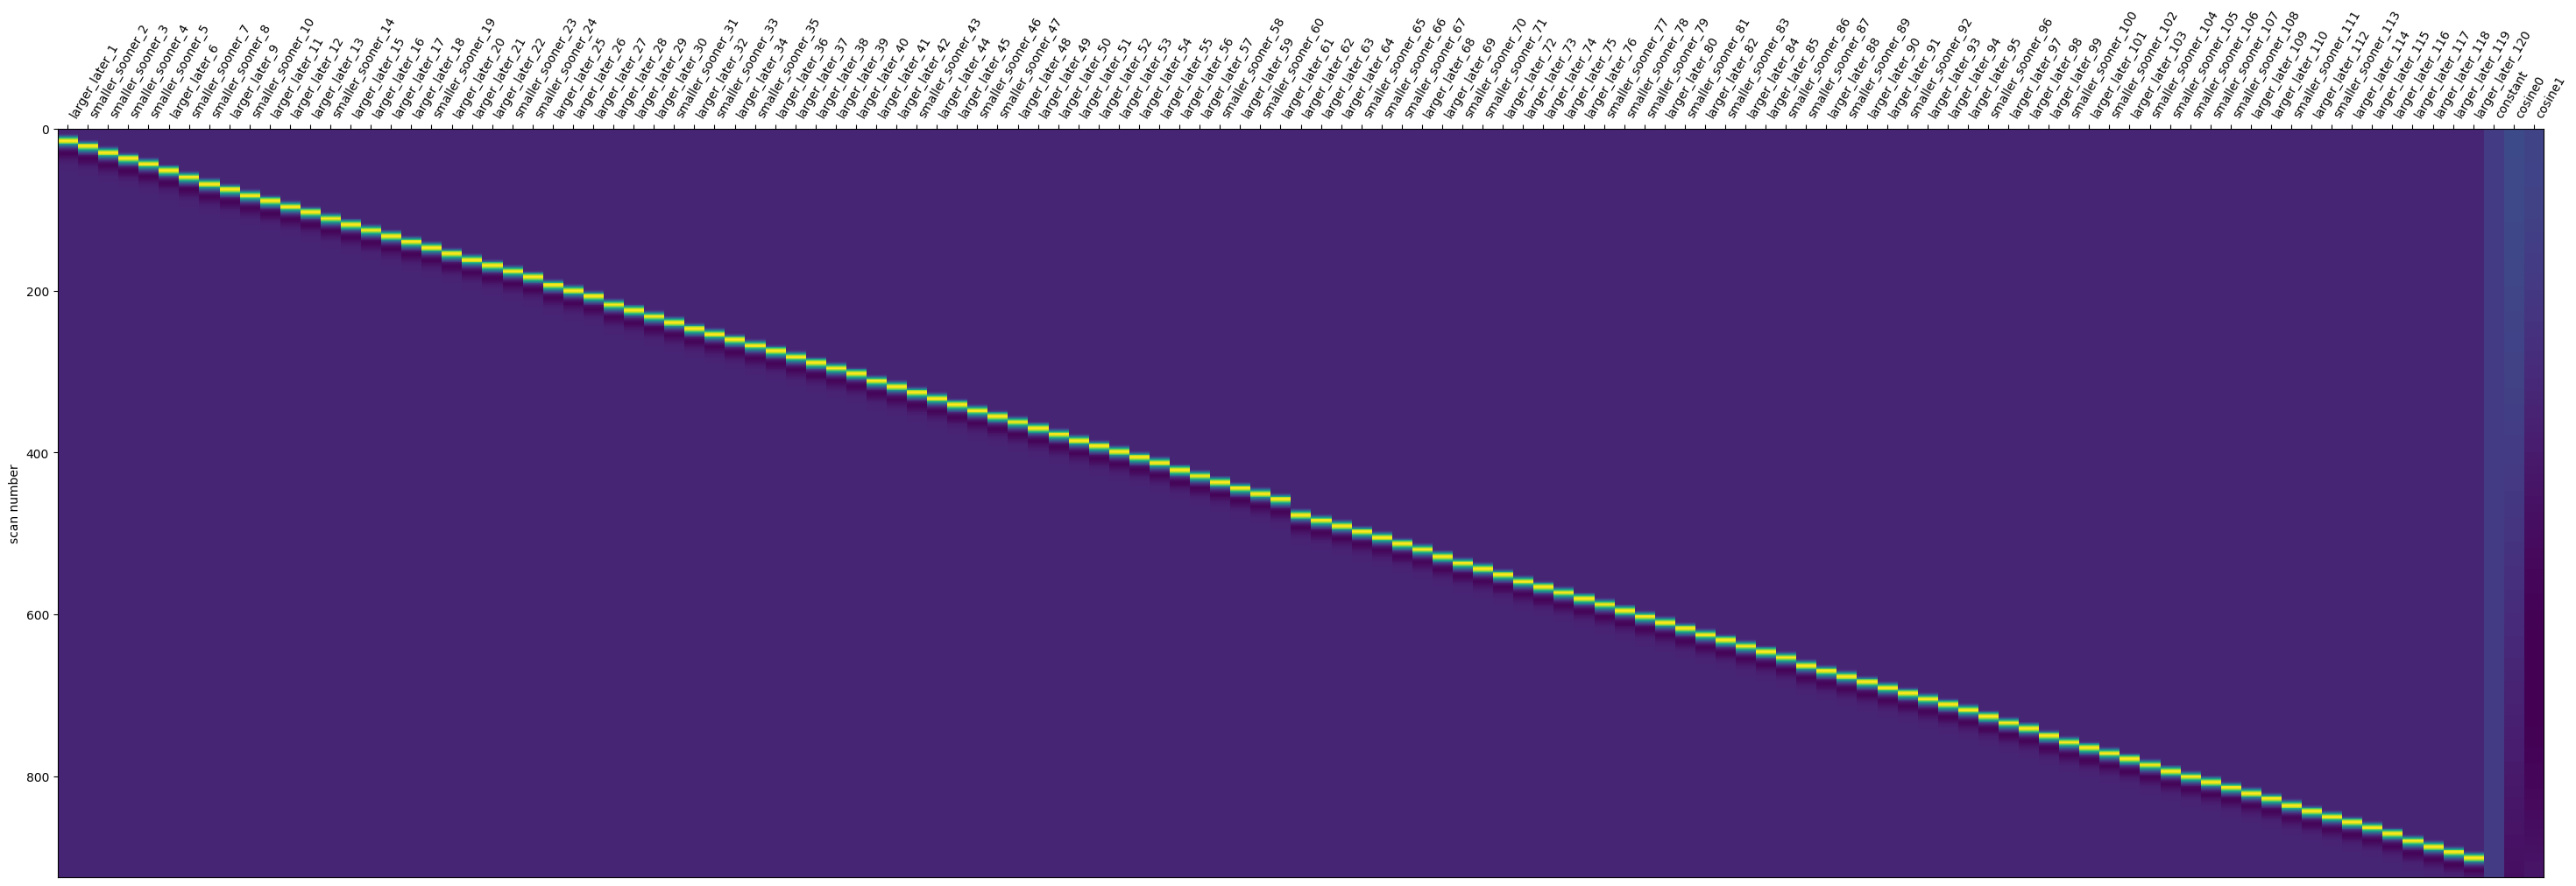

In [31]:
# model_subids, bold_paths, design_matrices
desmat = design_matrices[subind]
plot_design_matrix(desmat)
plt.show()

In [32]:
print(desmat.shape)
print(data_roi.shape)

(925, 123)
(984, 2674)


In [33]:
def compute_betas(desmat, data_array):
    """
    Compute OLS beta estimates for all voxels using matrix multiplication / einsum.

    Parameters
    ----------
    desmat : pd.DataFrame or np.ndarray
        Design matrix, shape (ntime x nbetas)
    data_array : np.ndarray
        Time series data, shape (ntime x nvox)

    Returns
    -------
    betas : np.ndarray
        Estimated betas, shape (nbetas x nvox)
    """
    # Ensure desmat is a numpy array
    X = np.asarray(desmat)  # (ntime x nbetas)
    Y = np.asarray(data_array)  # (ntime x nvox)

    # Compute (X^T X)^-1
    XtX_inv = np.linalg.inv(X.T @ X)  # (nbetas x nbetas)

    # Compute betas: (X^T X)^-1 X^T Y
    betas = np.einsum('ij,jk->ik', XtX_inv @ X.T, Y)  # (nbetas x nvox)

    return betas

In [35]:
desmat.shape

(925, 123)

In [36]:
data_roi.shape

(984, 2674)

In [34]:
betas = compute_betas(desmat, data_roi)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (123,925)->(123,newaxis,925) (984,2674)->(2674,984) 

In [ ]:
print(betas.shape)

In [ ]:
print(data.shape)

In [40]:
all_betas = compute_betas(desmat, data)

In [ ]:
all_betas.shape

# seems fast enough!
Glad it runs okay on the full brain of data.  Next up we just need to save the beta series to disc.  Here's a function for that.

In [42]:
from pathlib import Path

import pandas as pd
from nilearn.maskers import NiftiMasker


def save_beta_series(
    betas: np.ndarray,
    desmat,
    data_masker: NiftiMasker,
    subid: str,
    output_dir: str,
):
    """
    Save filtered beta series (only trial regressors) to NIfTI + CSV.

    Parameters
    ----------
    betas : np.ndarray
        Beta estimates, shape (nbetas, nvox).
    desmat : pd.DataFrame
        Design matrix with column labels (length = nbetas).
    data_masker : NiftiMasker
        Fitted masker used for inverse transform.
    subid : str
        Subject ID for file naming.
    output_dir : str
        Directory to save outputs.

    Returns
    -------
    labels : list of str
        Filtered labels corresponding to betas kept.
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Step 1: find columns of interest
    keep_mask = desmat.columns.str.contains(r'(?:smaller|larger|false)', regex=True)
    kept_labels = desmat.columns[keep_mask]

    # Step 2: simplify names (remove trailing "_number")
    simplified_labels = [re.sub(r'_\d+$', '', lbl) for lbl in kept_labels]

    # Step 3: filter betas
    betas_kept = betas[keep_mask, :]

    # Step 4: save 4D beta image
    beta_img = data_masker.inverse_transform(betas_kept)
    beta_file = output_path / f'sub-{subid}_beta_series.nii.gz'
    beta_img.to_filename(str(beta_file))

    # Step 5: save labels to CSV
    labels_file = output_path / f'sub-{subid}_beta_labels.csv'
    pd.Series(simplified_labels, name='beta_condition').to_csv(labels_file, index=False)

    print(f'Saved beta series: {beta_file}')
    print(f'Saved labels: {labels_file}')


In [ ]:
outdir = '/home/users/jmumford/josh/output/'
save_beta_series(betas, desmat, data_masker_roi, subid, outdir)

## That's a wrap!

Everything seems to work okay.  The necessary functions were collected into the main package modules in `src/delay_discounting_mvpa`.  Specifically in `design_utils.py`, `fmri_io.py`, `fmri_model.py`, and `io_utils.py`.  I then developed the lsa script, `analysis_code/scripts/run_lsa.py` and the corresponding bulk submit batch script, `analysis_code/scripts/run_lsa_all.batch`.  Note, that script requires a text list of all of the "good" subjects (subjects with data) and that was generated by `analysis_code/scripts/get_good_subids.py`.

Settings in the batch submit script likely need to be altered for use by different users.